In [ ]:
!nvidia-smi
#!nvidia-smi --gpu-reset


In [15]:
from collections import defaultdict
from itertools import islice
import random
import time
from pathlib import Path
import math

import numpy as np
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torchvision

import matplotlib.pyplot as plt

In [16]:
#combo omnigrok,satvik
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

def compute_accuracy(network, dataset, device, N=2000, batch_size=50):
    """Computes accuracy of `network` on `dataset`.
    """
    with torch.no_grad():
        N = min(len(dataset), N)
        batch_size = min(batch_size, N)
        dataset_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
        correct = 0
        total = 0
        for x, labels in islice(dataset_loader, N // batch_size):
            logits = network(x.to(device))
            predicted_labels = torch.argmax(logits, dim=1)
            correct += torch.sum(predicted_labels == labels.to(device))
            total += x.size(0)
        return (correct / total).item()

def compute_loss(network, dataset, loss_function, device, N=2000, batch_size=50):
    """Computes mean loss of `network` on `dataset`.
    """
    with torch.no_grad():
        N = min(len(dataset), N)
        batch_size = min(batch_size, N)
        dataset_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
        loss_fn = loss_function_dict[loss_function](reduction='sum')
        one_hots = torch.eye(10, 10).to(device)
        total = 0
        points = 0
        for x, labels in islice(dataset_loader, N // batch_size):
            y = network(x.to(device))
            if loss_function == 'CrossEntropy':
                total += loss_fn(y, labels.to(device)).item()
            elif loss_function == 'MSE':
                total += loss_fn(y, one_hots[labels]).item()
            points += len(labels)
        return total / points

In [17]:
optimizer_dict = {
    'AdamW': torch.optim.AdamW,
    'Adam': torch.optim.Adam,
    'SGD': torch.optim.SGD
}

activation_dict = {
    'ReLU': nn.ReLU,
    'Tanh': nn.Tanh,
    'Sigmoid': nn.Sigmoid,
    'GELU': nn.GELU
}

loss_function_dict = {
    'MSE': nn.MSELoss,
    'CrossEntropy': nn.CrossEntropyLoss
}

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F  
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import random
from itertools import cycle, islice
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import math
import weightwatcher as ww  



activation_dict = {"ReLU": nn.ReLU, "Tanh": nn.Tanh, "Sigmoid": nn.Sigmoid, "GELU": nn.GELU}
optimizer_dict = {"AdamW": optim.AdamW, "Adam": optim.Adam, "SGD": optim.SGD}
loss_function_dict = {"CrossEntropy": nn.CrossEntropyLoss, "MSE": nn.MSELoss}



experiment='wd_0.0_replicate'


download_directory = "."
train_points = 1000           
optimization_steps = 100000
batch_size = 200 
loss_function = 'MSE'         
optimizer = 'AdamW'           
weight_decay = 0.0     #very clear antigrok @0
lr = 5e-4
initialization_scale = 4.0
depth = 3                     
width = 200 # 
activation = 'ReLU'           
log_freq = math.ceil(optimization_steps / 150)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dtype = torch.float64
seed = 0


torch.set_default_dtype(dtype)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
random.seed(seed)
np.random.seed(seed)




train_dataset_full = torchvision.datasets.MNIST(
    root=download_directory, train=True,
    transform=transforms.ToTensor(), download=True
)
test_dataset = torchvision.datasets.MNIST(
    root=download_directory, train=False,
    transform=transforms.ToTensor(), download=True
)

samples_per_class = train_points // 10
indices = []
targets_np = train_dataset_full.targets.numpy()
for digit in range(10):
    digit_indices = np.where(targets_np == digit)[0]
    chosen_indices = np.random.choice(digit_indices, samples_per_class, replace=False)
    indices.extend(chosen_indices.tolist())

train_dataset = Subset(train_dataset_full, indices)
# ------------------------------------------------------------------------

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


fixed_train, _ = next(iter(train_loader))
fixed_train = fixed_train.to(device)

assert activation in activation_dict, f"Unsupported activation function: {activation}"
activation_fn = activation_dict[activation]




layers = [nn.Flatten()]
for i in range(depth):
    if i == 0:
        layers.append(nn.Linear(784, width))
        layers.append(activation_fn())
    elif i == depth - 1:
        layers.append(nn.Linear(width, 10))
    else:
        layers.append(nn.Linear(width, width))
        layers.append(activation_fn())
mlp = nn.Sequential(*layers).to(device)
with torch.no_grad():
    for p in mlp.parameters():
        p.data = initialization_scale * p.data

torch.save(mlp.state_dict(), f"model_initial_10m_{experiment}.pth")




assert optimizer in optimizer_dict, f"Unsupported optimizer choice: {optimizer}"
optimizer_instance = optimizer_dict[optimizer](mlp.parameters(), lr=lr, weight_decay=weight_decay)

assert loss_function in loss_function_dict, f"Unsupported loss function: {loss_function}"
loss_fn = loss_function_dict[loss_function]()




def get_weightwatcher_df(model):
    watcher = ww.WeightWatcher(model=model, log_level="ERROR")
    details = watcher.analyze(vectors=True, detX=True, plot=False,
                              fix_fingers='clip_xmax', randomize=True)
    return details



def create_model(config):
    layers = [nn.Flatten()]
    for i in range(config['depth']):
        if i == 0:
            layers.append(nn.Linear(784, config['width']))
            layers.append(config['activation']())
        elif i == config['depth'] - 1:
            layers.append(nn.Linear(config['width'], 10))
        else:
            layers.append(nn.Linear(config['width'], config['width']))
            layers.append(config['activation']())
    model = nn.Sequential(*layers).to(config['device'])
    with torch.no_grad():
        for p in model.parameters():
            p.data = config['initialization_scale'] * p.data
    return model

def model_pruner(base_model, kappa, config):
    pruned_model = create_model(config)
    state_dict = base_model.state_dict()
    new_state_dict = {}
    for key, value in state_dict.items():
        if 'weight' in key:
            new_state_dict[key] = F.dropout(value, p=kappa)
        else:
            new_state_dict[key] = value
    pruned_model.load_state_dict(new_state_dict)
    return pruned_model

def logit_kl_div(model1, model2, x_train, config):
    logits1 = model1(x_train)
    logits2 = model2(x_train)
    p1 = F.softmax(logits1, dim=1) + 1e-8
    p2 = F.softmax(logits2, dim=1) + 1e-8
    kl_div = torch.sum(p1 * (torch.log(p1) - torch.log(p2)), dim=1)
    return torch.mean(kl_div)

def progress_measures(model, x_train, layer_idx_sparsity=2, layer_idx_entropy=1, tau_sparsity=1, config=None):
    with torch.no_grad():
        x = x_train.clone().reshape(-1, 784)
        for i, layer in enumerate(model):
            x = layer(x)
            if i == layer_idx_sparsity:
                activation_val = x.detach()
                sparsity = torch.mean((activation_val < tau_sparsity).float()).item()
                diff = activation_val - tau_sparsity
                beta = 0.3
                smooth_comparison = torch.sigmoid(-diff / beta)
                diff_sparsity = torch.mean(smooth_comparison).item()
                break
        weight_layer = None
        if isinstance(model[layer_idx_entropy], nn.Linear):
            weight_layer = model[layer_idx_entropy]
        else:
            for j in range(layer_idx_entropy, len(model)):
                if isinstance(model[j], nn.Linear):
                    weight_layer = model[j]
                    break
        if weight_layer is None:
            weights_entropy = None
        else:
            weights_entropy = -torch.sum(torch.abs(weight_layer.weight) * torch.log(torch.abs(weight_layer.weight) + 1e-8)).item()
        
        pruned_model = model_pruner(model, 0.5, config)
        greedy_circuit_complexity = logit_kl_div(model, pruned_model, x_train, config).item()
    
    return sparsity, diff_sparsity, weights_entropy, greedy_circuit_complexity




def compute_accuracy(network, dataset, device, N=None):
    network.eval()
    correct, total = 0, 0
    loader = DataLoader(dataset, batch_size=256)
    with torch.no_grad():
        for x, labels in loader:
            x, labels = x.to(device), labels.to(device)
            logits = network(x)
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += x.size(0)
            if N is not None and total >= N:
                break
    network.train()
    return correct / total

def compute_loss(network, dataset, loss_function, device, N=None):
    network.eval()
    loss_total = 0
    total = 0
    one_hots = torch.eye(10, 10).to(device)
    loader = DataLoader(dataset, batch_size=256)
    with torch.no_grad():
        for x, labels in loader:
            x, labels = x.to(device), labels.to(device)
            logits = network(x)
            loss_total += loss_fn(logits, one_hots[labels]).item()
            total += x.size(0)
            if N is not None and total >= N:
                break
    network.train()
    return loss_total / total



train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
norms = []
last_layer_norms = []
log_steps = []

ww_alphas = []     
ww_lognorms = []    
ww_spectrals = []   
ww_steps = []

progress_sparsities = []          
progress_diff_sparsities = []     
progress_weights_entropies = []   
progress_greedy_complexities = [] 

ww_dfs = []

best_test_acc = -1.0

steps = 0
one_hots = torch.eye(10, 10).to(device)





with tqdm(total=optimization_steps) as pbar:
    for x, labels in islice(cycle(train_loader), optimization_steps):
        # Log metrics at the beginning and every log_freq steps
        if (steps < 30) or (steps < 150 and steps % 10 == 0) or steps % log_freq == 0:
            train_loss = compute_loss(mlp, train_dataset, loss_function, device, N=len(train_dataset))
            train_acc = compute_accuracy(mlp, train_dataset, device, N=len(train_dataset))
            test_loss = compute_loss(mlp, test_dataset, loss_function, device, N=len(test_dataset))
            test_acc = compute_accuracy(mlp, test_dataset, device, N=len(test_dataset))
            train_losses.append(train_loss)
            train_accuracies.append(train_acc)
            test_losses.append(test_loss)
            test_accuracies.append(test_acc)
            log_steps.append(steps)


            if test_acc > best_test_acc:
                best_test_acc = test_acc
                torch.save(mlp.state_dict(), f"model_best_test_acc_10m_{experiment}.pth")

            with torch.no_grad():
                total_norm = sum(torch.pow(p, 2).sum() for p in mlp.parameters())
                norms.append(float(np.sqrt(total_norm.item())))
                last_layer = sum(torch.pow(p, 2).sum() for p in mlp[-1].parameters())
                last_layer_norms.append(float(np.sqrt(last_layer.item())))
            
            details_df = get_weightwatcher_df(mlp)
            details_df["train_accuracy"] = train_acc
            details_df["test_accuracy"] = test_acc
            ww_dfs.append(details_df.copy())
            
            if 'alpha' in details_df.columns:
                valid_alphas = details_df['alpha'].dropna().to_numpy()
                avg_alpha = np.mean(valid_alphas) if len(valid_alphas) > 0 else None
            else:
                avg_alpha = None
            if 'lognorm' in details_df.columns:
                valid_lognorms = details_df['lognorm'].dropna().to_numpy()
                avg_lognorm = np.mean(valid_lognorms) if len(valid_lognorms) > 0 else None
            else:
                avg_lognorm = None
            if 'spectral_norm' in details_df.columns:
                valid_spectrals = details_df['spectral_norm'].dropna().to_numpy()
                avg_spectral = np.mean(valid_spectrals) if len(valid_spectrals) > 0 else None
            else:
                avg_spectral = None
            ww_alphas.append(avg_alpha)
            ww_lognorms.append(avg_lognorm)
            ww_spectrals.append(avg_spectral)
            ww_steps.append(steps)
            
            ps, pds, pwe, pgc = progress_measures(
                mlp, fixed_train, layer_idx_sparsity=2, layer_idx_entropy=1, tau_sparsity=1,
                config=locals()['config'] if 'config' in locals() else {
                    'train_points': train_points,
                    'batch_size': batch_size,
                    'loss_function': loss_fn,
                    'optimizer': optimizer_instance,
                    'weight_decay': weight_decay,
                    'lr': lr,
                    'initialization_scale': initialization_scale,
                    'download_directory': download_directory,
                    'depth': depth,
                    'width': width,
                    'activation': activation_fn,
                    'log_freq': log_freq,
                    'device': device,
                    'dtype': dtype,
                })
            progress_sparsities.append(ps)
            progress_diff_sparsities.append(pds)
            progress_weights_entropies.append(pwe)
            progress_greedy_complexities.append(pgc)
            
            desc = (f"Step {steps} | Train L: {train_loss:1.1e}, Test L: {test_loss:1.1e} | "
                    f"Acc: {train_acc*100:2.1f}%/{test_acc*100:2.1f}%")
            if avg_alpha is not None:
                desc += f" | WW α (avg): {avg_alpha:0.2f}"
            pbar.set_description(desc)
        
        optimizer_instance.zero_grad()
        y = mlp(x.to(device))
        if loss_function == 'CrossEntropy':
            loss_val = loss_fn(y, labels.to(device))
        elif loss_function == 'MSE':
            loss_val = loss_fn(y, one_hots[labels])
        loss_val.backward()
        optimizer_instance.step()
        steps += 1
        pbar.update(1)

torch.save(mlp.state_dict(), f"model_final_10m_{experiment}.pth")


full_ww_df = pd.concat(ww_dfs, keys=log_steps, names=["Step", "Row"]).reset_index()
full_ww_df.to_csv(f"weightwatcher_full_history_balanced_10m_{experiment}.csv", index=False)

progress_df = pd.DataFrame({
    "Step": log_steps,
    "train_accuracy": train_accuracies,
    "test_accuracy": test_accuracies,
    "progress_sparsity": progress_sparsities,
    "progress_diff_sparsity": progress_diff_sparsities,
    "progress_weights_entropy": progress_weights_entropies,
    "progress_greedy_complexity": progress_greedy_complexities,
})
progress_df.to_csv(f"progress_measures_history_10m_{experiment}.csv", index=False)




Step 99383 | Train L: 4.3e-08, Test L: 8.4e-05 | Acc: 100.0%/90.5% | WW α (avg): 3.56: 100%|█| 100000/100000 [19:11<00:0


Text(0.5, 1.0, 'depth-3 width-200 ReLU MLP on MNIST\n  initialization scale(α) = 4.0')

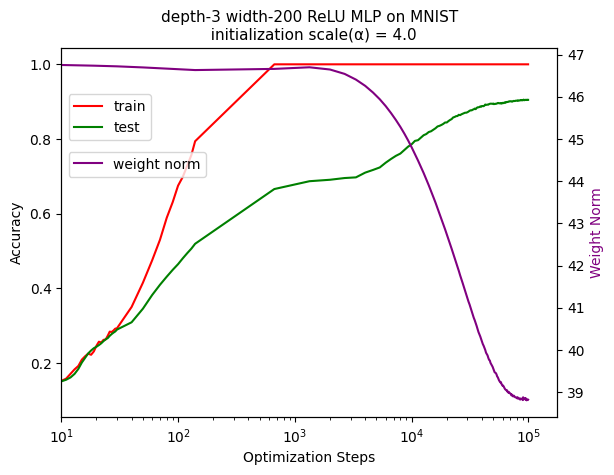

In [22]:
ax = plt.subplot(1, 1, 1)
plt.plot(log_steps, train_accuracies, color='red', label='train')
plt.plot(log_steps, test_accuracies, color='green', label='test')
plt.xscale('log')
plt.xlim(10, None)
plt.xlabel("Optimization Steps")
plt.ylabel("Accuracy")
plt.legend(loc=(0.015, 0.75))

ax2 = ax.twinx()
ax2.set_ylabel("Weight Norm", color='purple')
ax2.plot(log_steps, norms, color='purple', label='weight norm')
# ax2.set_ylim(27, 63)
plt.legend(loc=(0.015, 0.65))
plt.title(f"depth-3 width-200 ReLU MLP on MNIST\n  initialization scale(α) = {initialization_scale}", fontsize=11)
# plt.tight_layout()

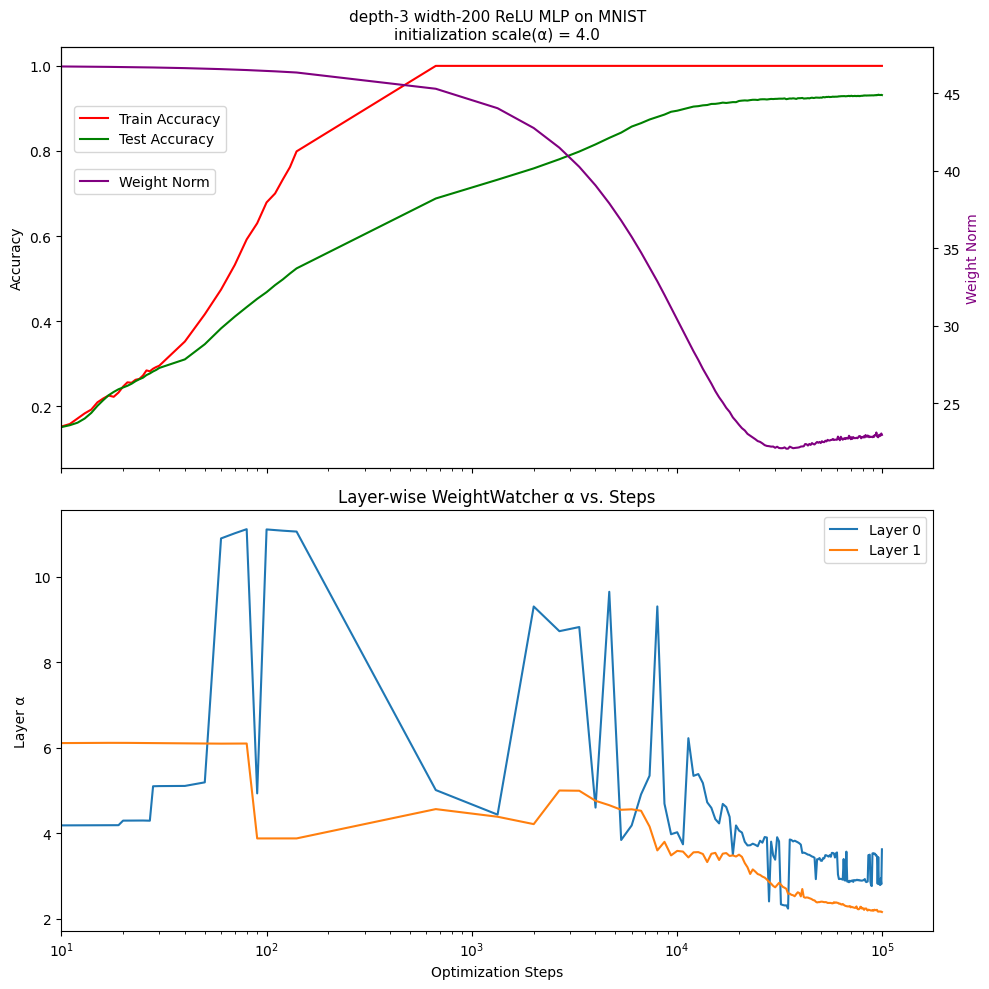

In [20]:

import pandas as pd
import matplotlib.pyplot as plt

alpha_pivot = full_ww_df.pivot(index="Step", columns="Row", values="alpha")

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 10))

ax1.plot(log_steps, train_accuracies, color='red', label='Train Accuracy')
ax1.plot(log_steps, test_accuracies, color='green', label='Test Accuracy')
ax1.set_xscale('log')
ax1.set_xlim(10, None)
ax1.set_ylabel("Accuracy")
ax1.legend(loc=(0.015, 0.75))
ax1.set_title(
    f"depth-3 width-200 ReLU MLP on MNIST\ninitialization scale(α) = {initialization_scale}",
    fontsize=11
)

ax1_twin = ax1.twinx()
ax1_twin.set_ylabel("Weight Norm", color='purple')
ax1_twin.plot(log_steps, norms, color='purple', label='Weight Norm')
ax1_twin.legend(loc=(0.015, 0.65))

for layer in alpha_pivot.columns[:2]:
    ax2.plot(
        alpha_pivot.index,
        alpha_pivot[layer],
        label=f'Layer {layer}'
    )
ax2.set_xscale('log')
ax2.set_xlim(10, None)
ax2.set_xlabel("Optimization Steps")
ax2.set_ylabel("Layer α")
ax2.legend(loc='best')
ax2.set_title("Layer-wise WeightWatcher α vs. Steps")

plt.tight_layout()
plt.show()


In [35]:
import pandas as pd

weightnorm_df = pd.DataFrame({
    'Step': log_steps,
    'WeightNorm': norms
})

weightnorm_df.to_csv('weight_norms_history_replicate3.csv', index=False)


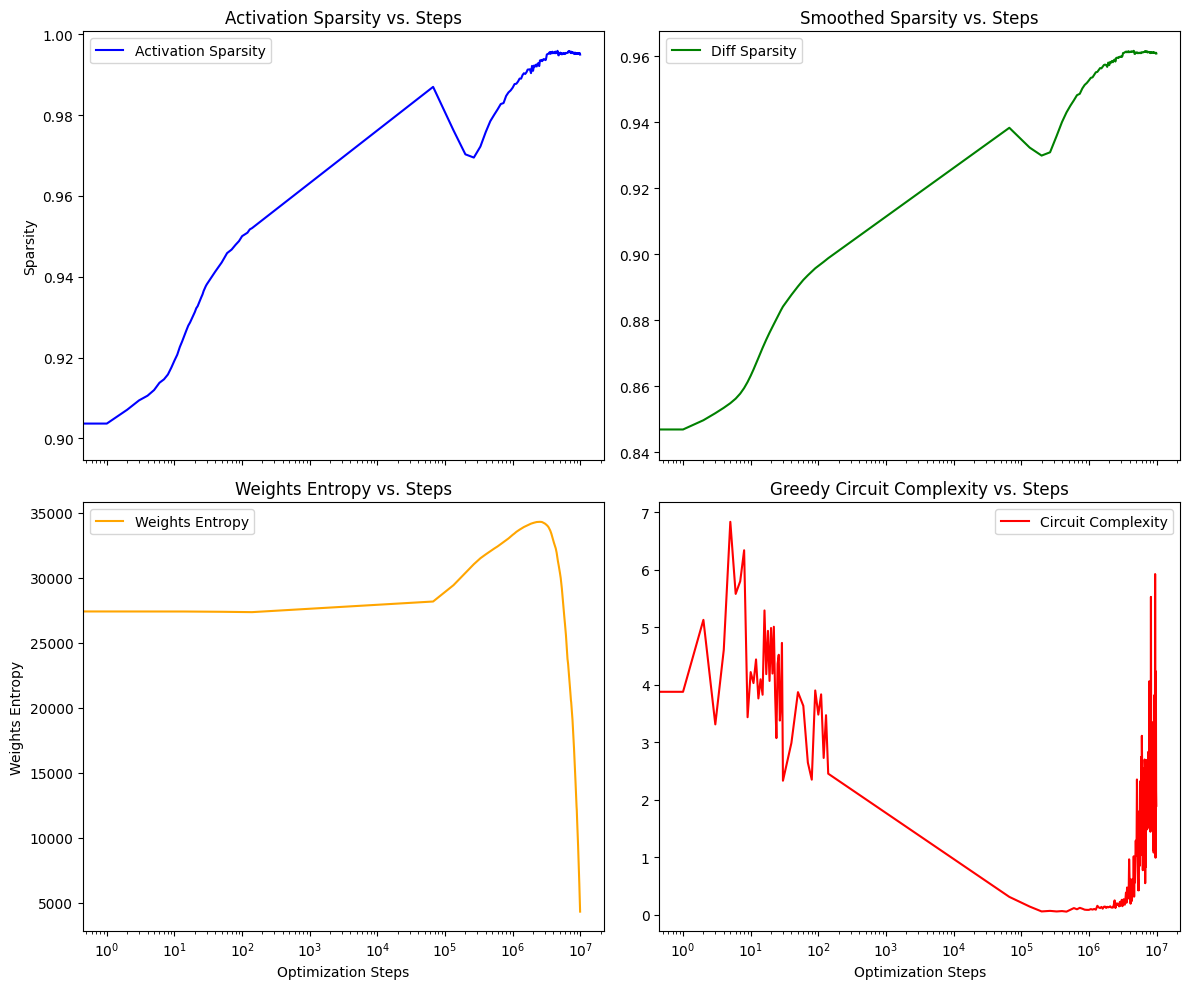

In [13]:
import matplotlib.pyplot as plt


fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=True)

axes[0, 0].semilogx(log_steps, progress_sparsities,
                    label="Activation Sparsity", color='blue')
axes[0, 0].set_ylabel("Sparsity")
axes[0, 0].set_title("Activation Sparsity vs. Steps")
axes[0, 0].legend()

axes[0, 1].semilogx(log_steps, progress_diff_sparsities,
                    label="Diff Sparsity", color='green')
axes[0, 1].set_title("Smoothed Sparsity vs. Steps")
axes[0, 1].legend()


axes[1, 0].semilogx(log_steps, progress_weights_entropies,
                    label="Weights Entropy", color='orange')
axes[1, 0].set_xlabel("Optimization Steps")
axes[1, 0].set_ylabel("Weights Entropy")
axes[1, 0].set_title("Weights Entropy vs. Steps")
axes[1, 0].legend()

axes[1, 1].semilogx(log_steps, progress_greedy_complexities,
                    label="Circuit Complexity", color='red')
axes[1, 1].set_xlabel("Optimization Steps")
axes[1, 1].set_title("Greedy Circuit Complexity vs. Steps")
axes[1, 1].legend()

fig.tight_layout()
plt.show()



--- Analyzing model: model_final_10m_wd_0_repli6.pth ---
Successfully loaded model from model_final_10m_wd_0_repli6.pth
Running WeightWatcher for model_final_10m_wd_0_repli6.pth...


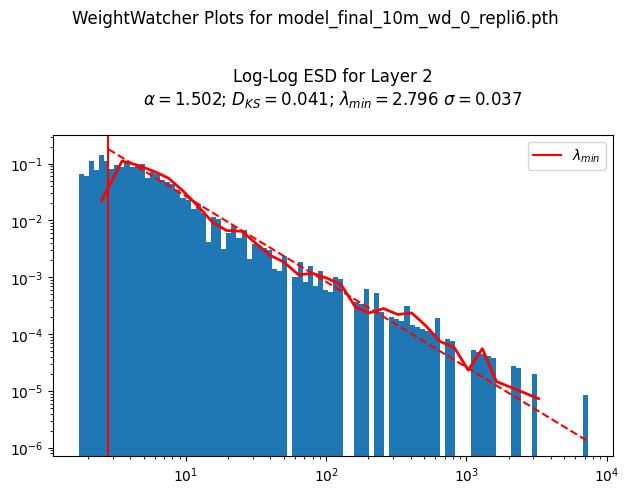

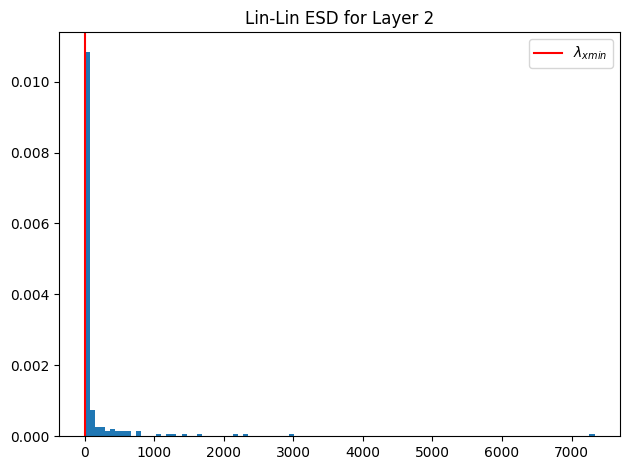

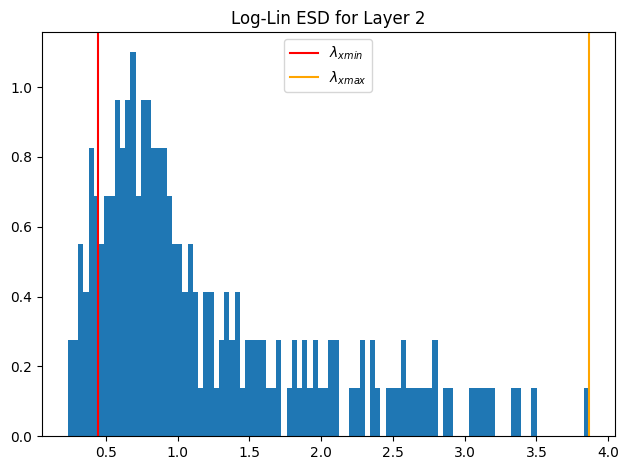

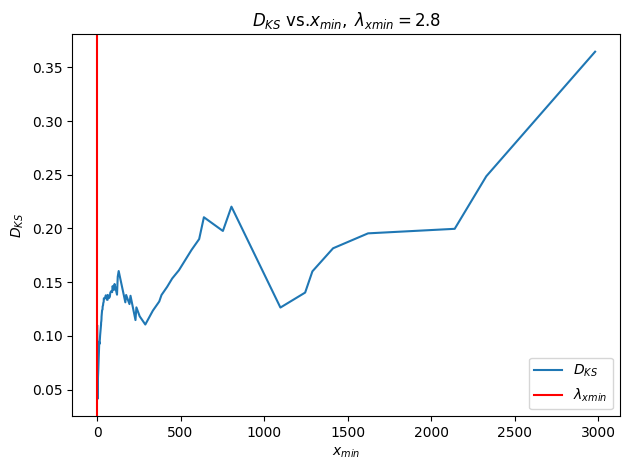

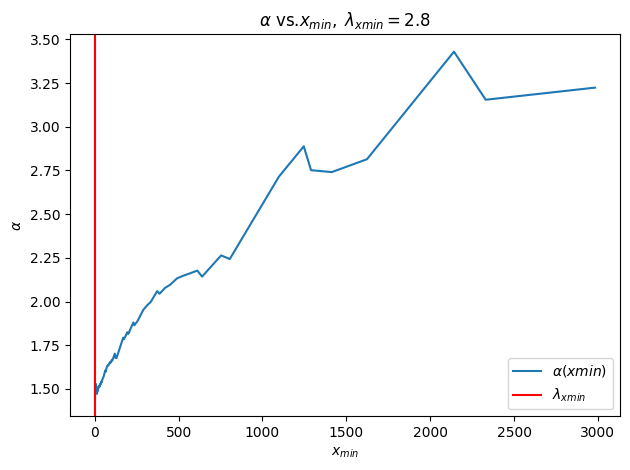

<Figure size 640x480 with 0 Axes>

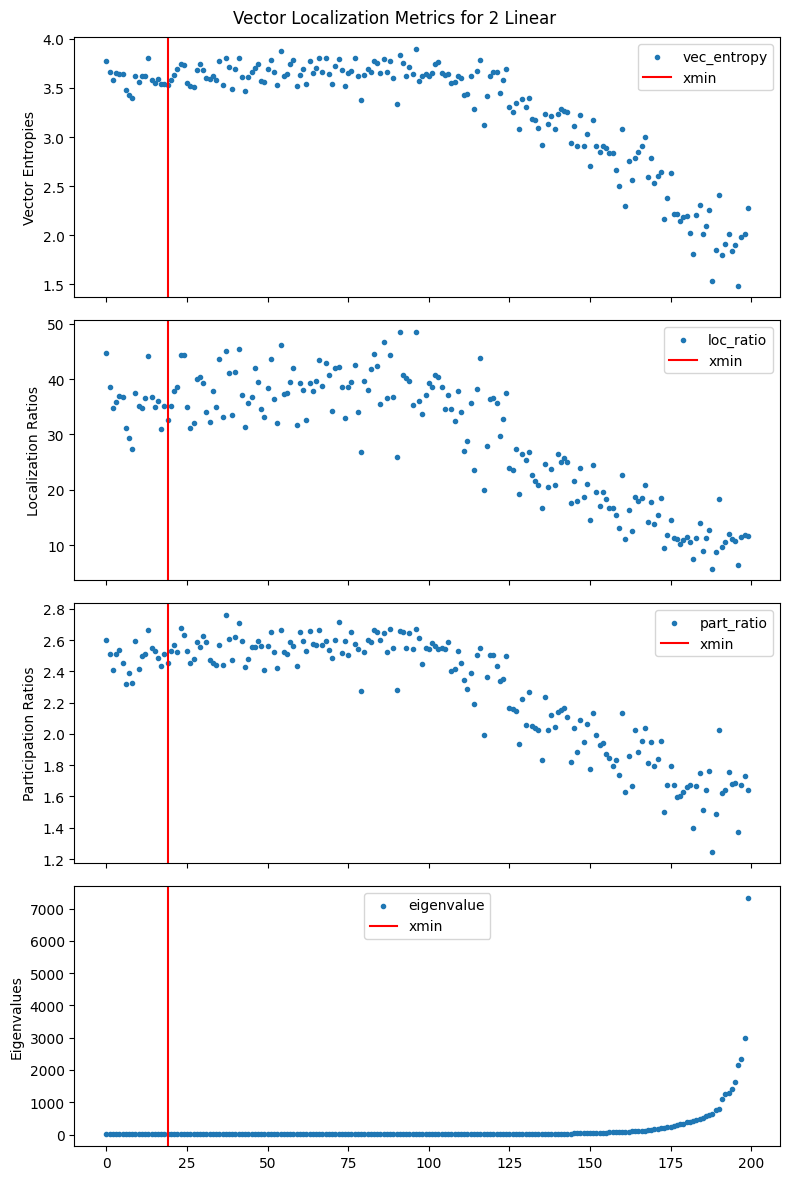

<Figure size 640x480 with 0 Axes>

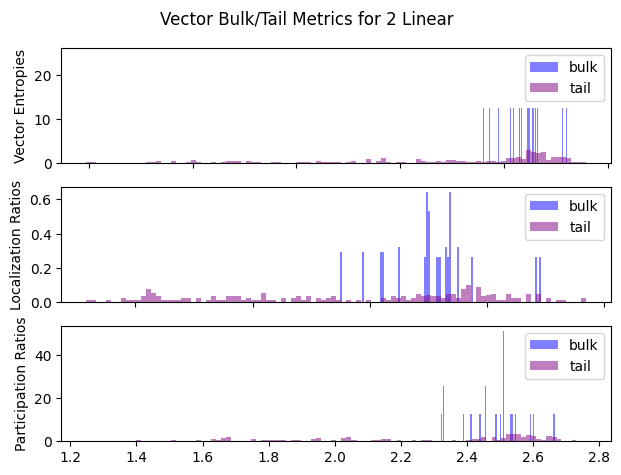

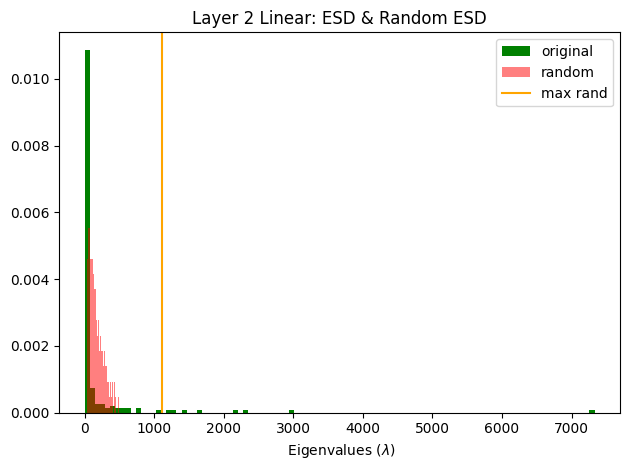

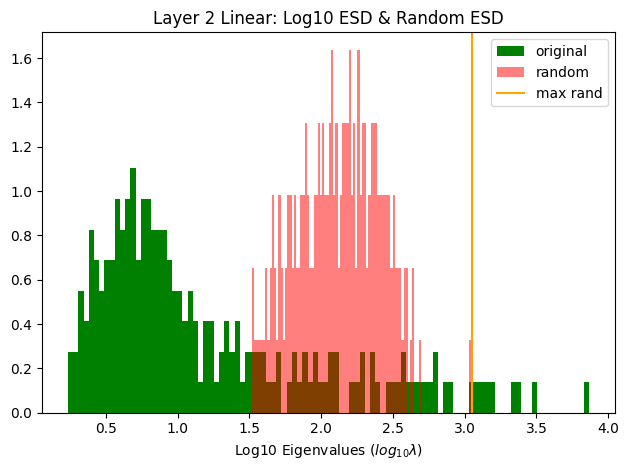

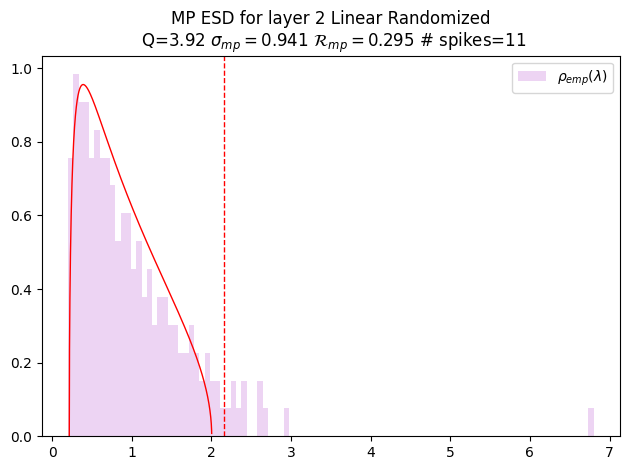

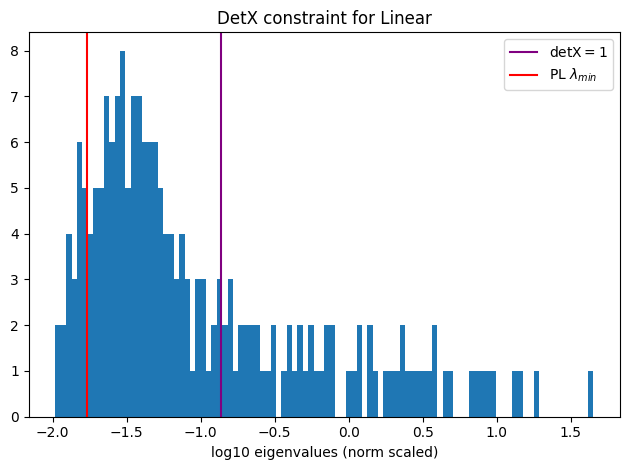

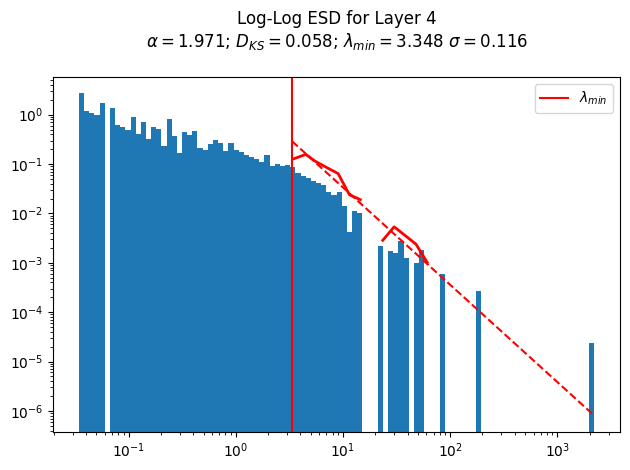

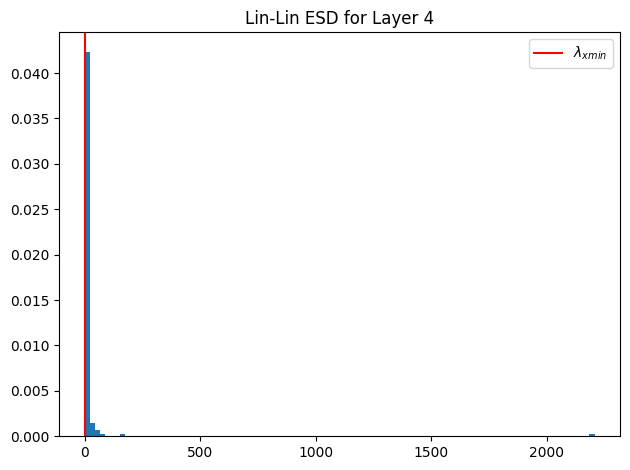

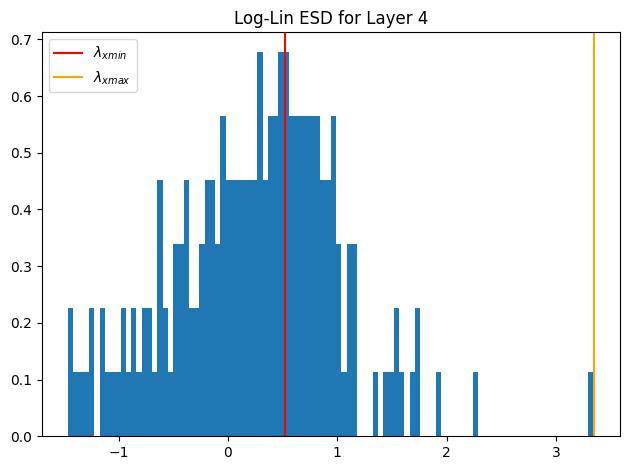

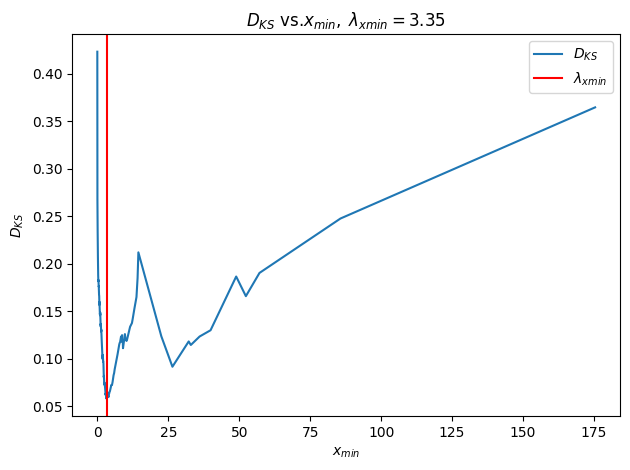

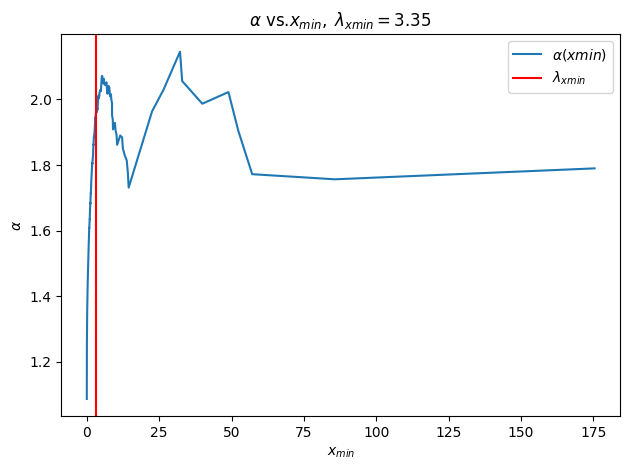

<Figure size 640x480 with 0 Axes>

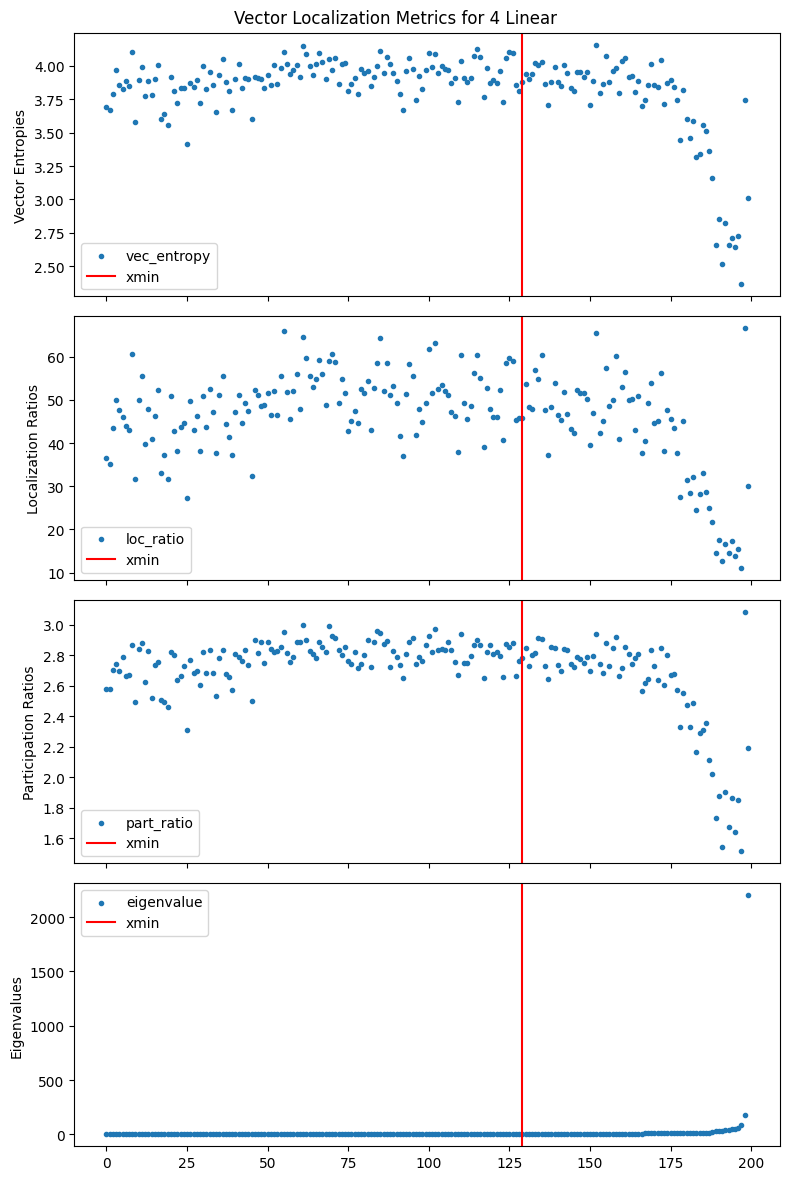

<Figure size 640x480 with 0 Axes>

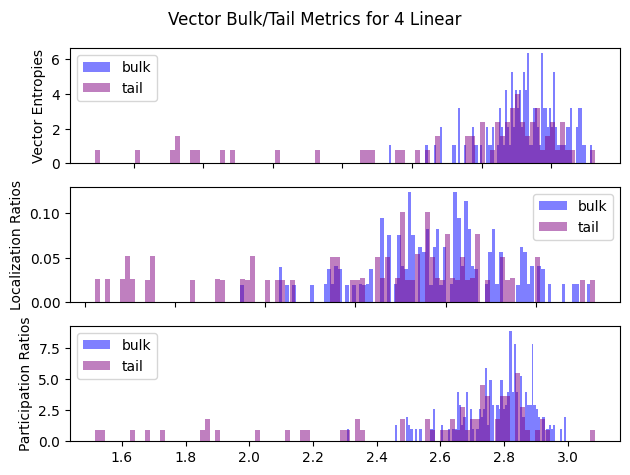

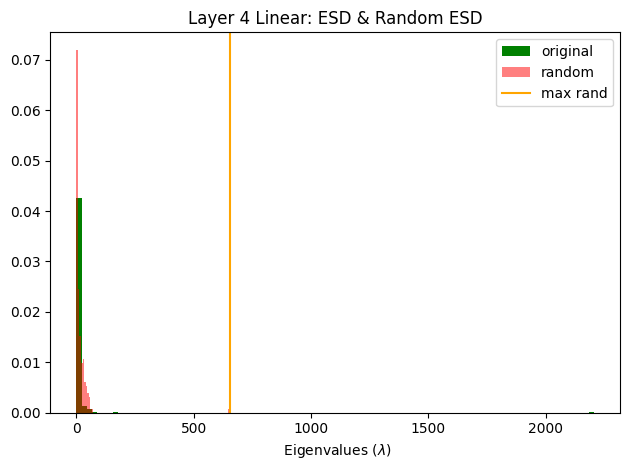

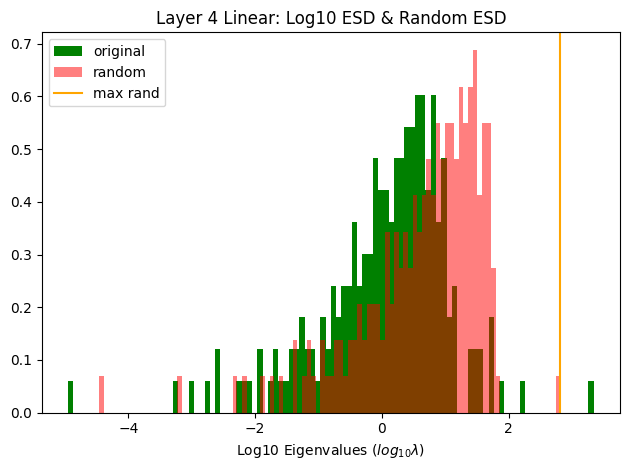

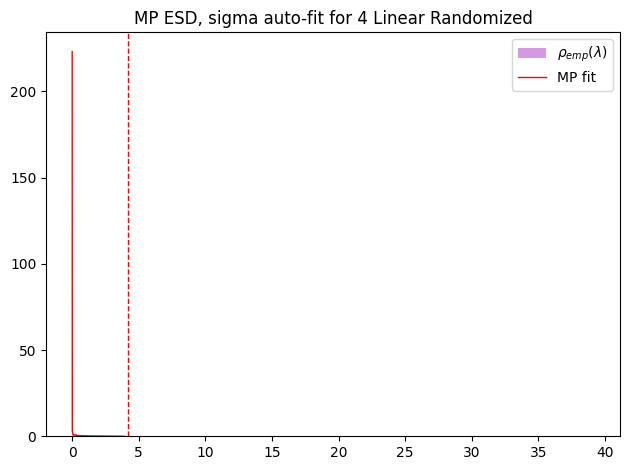

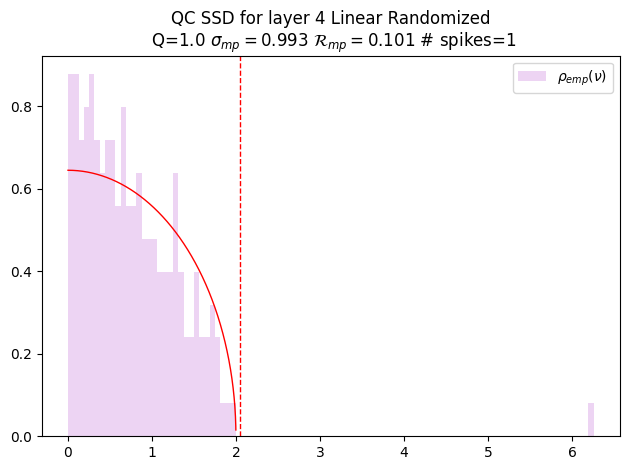

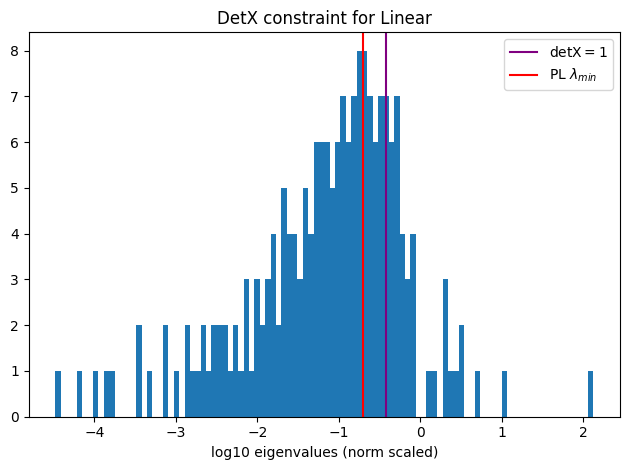

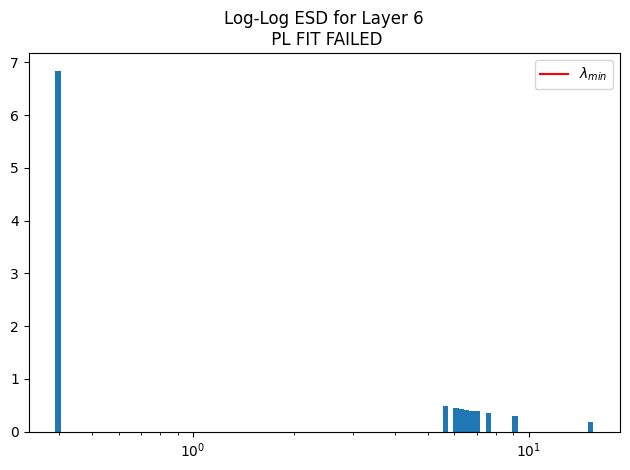

donezo

WeightWatcher Analysis Details for model_final_10m_wd_0_repli6.pth:


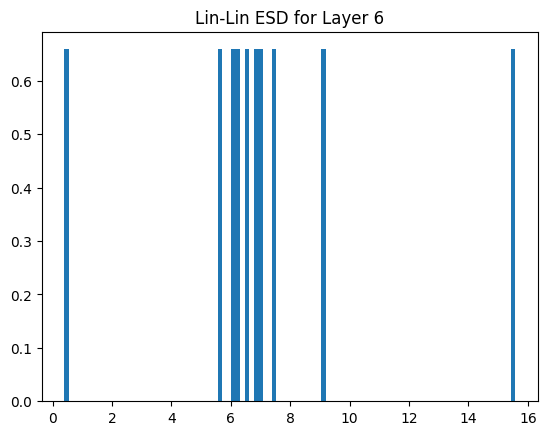


--- All models analyzed ---


In [34]:
import torch
import torch.nn as nn
import weightwatcher as ww
import matplotlib.pyplot as plt 

activation_dict = {"ReLU": nn.ReLU, "Tanh": nn.Tanh, "Sigmoid": nn.Sigmoid, "GELU": nn.GELU}

depth = 3
width = 200
activation_name = 'ReLU' 
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dtype = torch.float64 
initialization_scale = 8.0 

torch.set_default_dtype(dtype)


def create_model(config):
    layers = [nn.Flatten()]
    activation_fn = activation_dict[config['activation_name']]
    for i in range(config['depth']):
        if i == 0:
            layers.append(nn.Linear(784, config['width'])) # MNIST images are 28x28 = 784
            layers.append(activation_fn())
        elif i == config['depth'] - 1:
            layers.append(nn.Linear(config['width'], 10)) # MNIST has 10 classes
        else:
            layers.append(nn.Linear(config['width'], config['width']))
            layers.append(activation_fn())
    model = nn.Sequential(*layers).to(config['device'])
    with torch.no_grad():
        for p in model.parameters():
            p.data = config['initialization_scale'] * p.data
    return model

model_config = {
    'depth': depth,
    'width': width,
    'activation_name': activation_name,
    'device': device,
    'initialization_scale': initialization_scale,
}

model_paths = [
    "model_final_10m_wd_0_repli6.pth"
]

for model_path in model_paths:
    print(f"\n--- Analyzing model: {model_path} ---")


    mlp = create_model(model_config)


    try:
        mlp.load_state_dict(torch.load(model_path, map_location=device))
        print(f"Successfully loaded model from {model_path}")
    except Exception as e:
        print(f"Error loading model from {model_path}: {e}")
        continue 
    mlp.eval()

    print(f"Running WeightWatcher for {model_path}...")
    try:
        plt.suptitle(f"WeightWatcher Plots for {model_path}", y=1.02) 

        watcher = ww.WeightWatcher(model=mlp, log_level="ERROR") # Using model=mlp
        details = watcher.analyze(
            vectors=True,
            detX=True,
            plot=True, 
            fix_fingers='clip_xmax',
            randomize=True
        )
        
    except:
        print('donezo')
    print(f"\nWeightWatcher Analysis Details for {model_path}:")



    plt.show() 
print("\n--- All models analyzed ---")